In [1]:
! pip install 'cebra[dev,demos]' 

  Using cached jupyter-1.0.0-py2.py3-none-any.whl (2.7 kB)
  Using cached nbconvert-7.16.2-py3-none-any.whl (257 kB)
  Using cached pylint-3.1.0-py3-none-any.whl (515 kB)
  Using cached toml-0.10.2-py2.py3-none-any.whl (16 kB)
  Using cached yapf-0.40.2-py3-none-any.whl (254 kB)
  Using cached black-24.3.0-cp311-cp311-macosx_11_0_arm64.whl (1.4 MB)
  Using cached isort-5.13.2-py3-none-any.whl (92 kB)
  Using cached coverage-7.4.4-cp311-cp311-macosx_11_0_arm64.whl (206 kB)
  Using cached pytest-8.1.1-py3-none-any.whl (337 kB)
  Using cached pytest_benchmark-4.0.0-py3-none-any.whl (43 kB)
  Using cached pytest_xdist-3.5.0-py3-none-any.whl (42 kB)
  Using cached pytest_timeout-2.3.1-py3-none-any.whl (14 kB)
  Using cached pytest_sphinx-0.6.0-py3-none-any.whl (10 kB)
  Using cached tables-3.8.0.tar.gz (8.0 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run 

In [2]:
import sys
import os # my addtion

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import cebra.datasets
from cebra import CEBRA
import torch
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Slider

from sklearn import manifold
from sklearn.decomposition import PCA

from matplotlib.collections import LineCollection
import pandas as pd

/Users/brian.gitahi/Desktop/AIND/CEBRA Analysis/CEBRA13/cebraenv/lib/python3.11/site-packages/cebra/datasets/__init__.py:103: UserWarning: Could not initialize one or more datasets: No module named 'h5py'. For using the datasets, consider installing the [datasets] extension via pip.
  warnings.warn(f"Could not initialize one or more datasets: {e}. "


This notebook will make an animation of the cebra embeddings: eventually will be converted to a function to animate the embeddings

In [3]:
iterations = 2000

In [4]:
# GET THIS FROM A LIBRARY SCRIPT LATER
def base_embed(input, temp=1, dimension=3, lr = 0.01, d=0.1):

    # build CEBRA time model
    model = CEBRA(model_architecture='offset1-model',
                         batch_size=512,
                         learning_rate=int(lr),
                         temperature=int(temp),
                         output_dimension = int(dimension),
                         max_iterations=iterations,
                         distance='euclidean',
                         delta=int(d),
                         conditional='delta',
                         device='cuda_if_available',
                         num_hidden_units=64,
                         verbose=True,
                         time_offsets=1)

    model.fit(input)
    embedding = model.transform(input)
    return model, embedding

In [5]:

# function to make a circle, that takes in number of data-points
def make_circle(n_points=100, r=1):

    # Define the center and radius of the circle
    center = (0, 0)
    radius = r

    # Create an array of angles from 0 to 2*pi
    theta = np.linspace(0, 2*np.pi, n_points)

    # Calculate the x and y coordinates of the circle
    x = center[0] + radius * np.cos(theta)
    x = x.reshape(-1,1)

    y = center[1] + radius * np.sin(theta)
    y = y.reshape(-1,1)

    # add the 3rd dimension (z coordinate of 0)
    z = np.zeros(n_points)
    z = z.reshape(-1,1)

    circle = np.concatenate((x,y,z), axis=1)

    return circle

# function to plot the circle
def plot_circle(x,y,z=0):
    # Create a figure and axis
    fig = plt.figure()
    ax = plt.subplot(111,projection='3d')
    # Plot the circle
    ax.plot(x, y, z, label='Circle')

    # Show the plot
    plt.show()



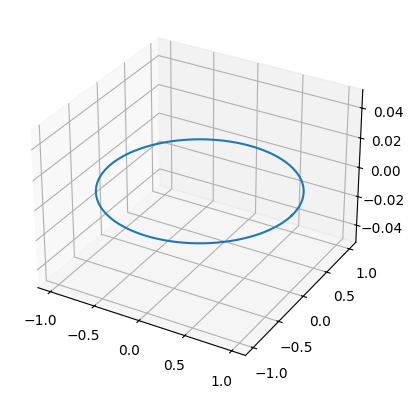

(100, 3)

In [6]:
%matplotlib inline
circle = make_circle()
plot_circle(circle[:,0], circle[:,1])
circle.shape

In [7]:
# define a function to make a lorenz system
def lorenz(t, xyz, sigma=10, rho=28, beta=8/3):
    x, y, z = xyz
    dxdt = sigma * (y - x)
    dydt = rho * x - y - x * z
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]


# Define parameters and initial conditions
sigma = 10
rho = 28
beta = 8/3
initial_conditions = [0, 2, 0]  # Initial conditions for [x, y, z]

# Time span for integration
t_span = [0, 35]

# Solve the differential equations
solution = solve_ivp(lorenz, t_span, initial_conditions, args=(sigma, rho, beta), dense_output=True)

# Generate time points for plotting
t = np.linspace(t_span[0], t_span[1], 10000)

# Evaluate the solution at the time points
xyz = solution.sol(t)

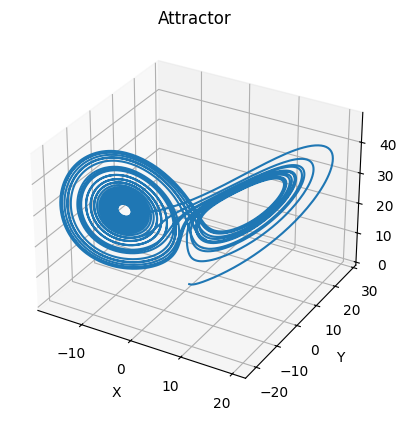

In [8]:
# Plot the Lorenz attractor
def plot_lorenz(coords):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(coords[0], coords[1], coords[2], alpha=1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Attractor')
    plt.show()


plot_lorenz(xyz)

In [9]:
# reshape the lorenz object for use with cebra
lorenz_obj = xyz.reshape(10000,3)
lorenz_obj.shape

(10000, 3)

In [10]:
# ideal model for circle and lorenz inputs
ideal_model, ideal_embedding = base_embed(input=circle, temp=1, dimension=3, lr = 0.1, d=0.1) 
ideal_model_l, ideal_embedding_l = base_embed(input=lorenz_obj, temp=1,dimension=3, lr=0.01, d=1)

pos:  0.0000 neg:  6.2259 total:  6.2259 temperature:  1.0000: 100%|██████████| 2000/2000 [00:22<00:00, 89.78it/s]
pos:  0.0043 neg:  5.8454 total:  5.8497 temperature:  1.0000: 100%|██████████| 2000/2000 [00:21<00:00, 93.87it/s]


<Axes3D: title={'center': 'Lorenz Attractor'}>

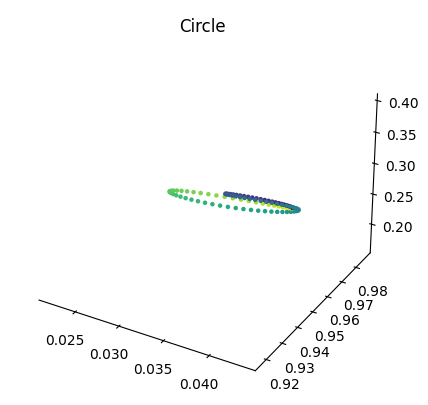

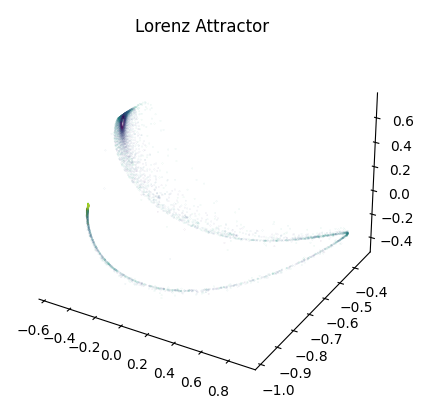

In [11]:
cebra.plot_embedding(ideal_embedding, embedding_labels='time', markersize=5, alpha=1, title='Circle')
cebra.plot_embedding(ideal_embedding_l, embedding_labels='time', markersize=0.001, alpha=1, title='Lorenz Attractor')

Ok, now that we have some embeddigns and useful inputs to animate, let's make a function to animate them.

In [24]:
def animate_attractor(attractor):

    model_pl2, embed_pl2 = base_embed(attractor, dimension=2)
    model_pl3, embed_pl3 = base_embed(attractor, dimension=3)

    # define the grid and axes
    fig = plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(2, 2, figure=fig) 
    ax1 = plt.subplot(gs[0, :], projection='3d')
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1], projection='3d')


    def update(i):
            ax1.clear()
            ax2.clear()
            ax3.clear()

            attractor_p = attractor[:, :i + 1000]

            ax1.plot(attractor_p[0], attractor_p[1], attractor_p[2], alpha=1)
            ax1.set_title('Timestep {}'.format(i + 1000))

            cebra.plot_embedding(embedding=embed_pl2[0:i + 1000, :], embedding_labels= 'time', markersize=5, ax=ax2)
            cebra.plot_embedding(embedding=embed_pl3[0:i + 1000, :], embedding_labels='time', markersize=5, ax=ax3)

    anima = FuncAnimation(fig, update, frames=range(0, attractor.shape[1], 1000), blit=False, interval=700, repeat=True)
    plt.show()
    anima.save("anima.gif", writer='pillow')

  0%|          | 0/2000 [00:00<?, ?it/s]

pos:  0.0157 neg:  5.4932 total:  5.5088 temperature:  1.0000: 100%|██████████| 2000/2000 [00:22<00:00, 86.99it/s]
pos:  0.0009 neg:  5.7601 total:  5.7610 temperature:  1.0000: 100%|██████████| 2000/2000 [00:22<00:00, 89.91it/s]


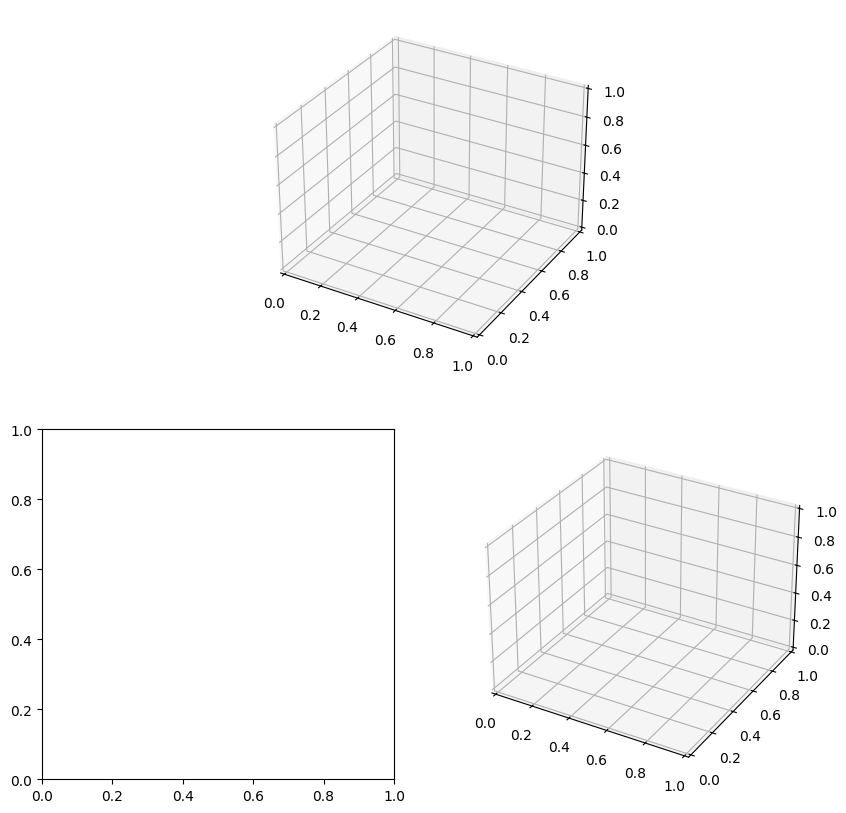

In [25]:
animate_attractor(lorenz_obj)

/Users/brian.gitahi/Desktop/AIND/CEBRA Analysis/CEBRA13/cebraenv/lib/python3.11/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


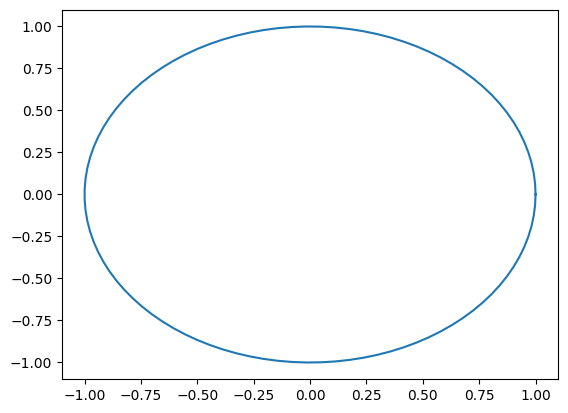

In [14]:
# simpler test version
plt.plot(circle[:,0], circle[:,1])

In [15]:
%matplotlib inline

fig = plt.figure(figsize=(15,15))

x,y = [], []
def animate(i):
    x.append(next(count()))
    y.append(random.randint(2,20))
    
    plt.style.use("ggplot")    
    plt.plot(x,y)

ani = FuncAnimation(fig, animate, interval=300)
plt.show()

/var/folders/zy/yd8f_r21629f1sr6zfh12jv40000gp/T/ipykernel_85662/2257727900.py:13: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, animate, interval=300)


<Figure size 1500x1500 with 0 Axes>

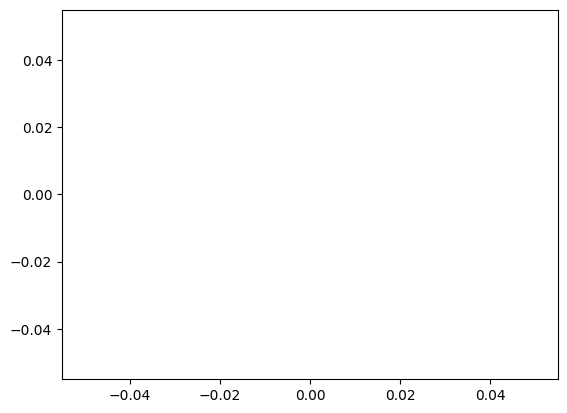

In [22]:
%matplotlib inline

# Sample data
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Create figure and axis
fig, ax = plt.subplots()
line, = ax.plot(x[0], y[0], lw=2)

# Initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# Animation function: this is called sequentially
def animate(i):
    x_data = x[:i]
    y_data = y[:i]
    line.set_data(x_data, y_data)
    return line,

# Create animation
anim = FuncAnimation(fig, animate, frames=len(x), interval=1000, blit=True)

plt.show()
anim.save('test_ani_1.gif', writer='pillow')

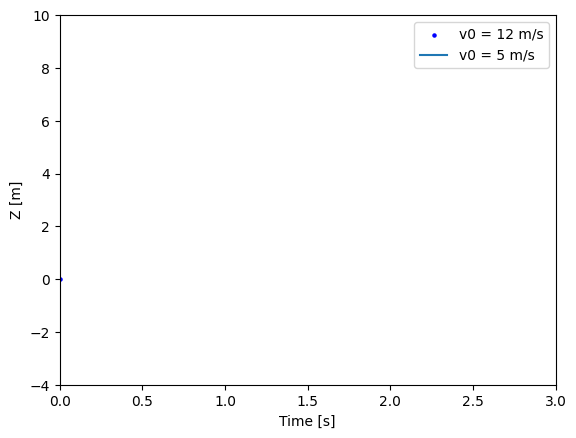

In [19]:
%matplotlib inline
is_manual = False # True if user has taken control of the animation

fig, ax = plt.subplots()
t = np.linspace(0, 3, 40)
g = -9.81
v0 = 12
z = g * t**2 / 2 + v0 * t

v02 = 5
z2 = g * t**2 / 2 + v02 * t

scat = ax.scatter(t[0], z[0], c="b", s=5, label=f'v0 = {v0} m/s')
line2 = ax.plot(t[0], z2[0], label=f'v0 = {v02} m/s')[0]
ax.set(xlim=[0, 3], ylim=[-4, 10], xlabel='Time [s]', ylabel='Z [m]')
ax.legend()

def update(frame):
    # for each frame, update the data stored on each artist.
    x = t[:frame]
    y = z[:frame]
    # update the scatter plot:
    data = np.stack([x, y]).T
    scat.set_offsets(data)
    # update the line plot:
    line2.set_xdata(t[:frame])
    line2.set_ydata(z2[:frame])
    return (scat, line2)



ani = FuncAnimation(fig=fig, func=update, frames=40, interval=300)
plt.show()
ani.save('test_ani.gif', writer='pillow')